In [ ]:

import re
from datetime import datetime
import pandas as pd
import numpy as np
# 🔍 --- Step 1: Read Apache Log File ---
log_file_path = "github_repo/Datasets/Apache.log" # 📝 Replace with actual .log file path

log_lines1 = []
with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
    log_lines1 = file.readlines()

In [2]:
# %% [markdown]
# # Step 1: Data Collection and Preprocessing
# 
# This section parses sample Apache log lines, cleans the data, converts timestamps to ISO 8601, and sets the timestamp as the index.



# Sample Apache log lines (replace with file read in a real scenario)
log_lines = [
    "[Thu Jun 09 06:07:04 2005] [notice] LDAP: Built with OpenLDAP LDAP SDK",
    "[Thu Jun 09 06:07:04 2005] [notice] LDAP: SSL support unavailable",
    "[Thu Jun 09 06:07:04 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)",
    "[Thu Jun 09 06:07:05 2005] [notice] Digest: generating secret for digest authentication ...",
    "[Thu Jun 09 06:07:05 2005] [error] env.createBean2(): Factory error creating channel.jni:jni ( channel.jni, jni)",
    "[Thu Jun 09 06:07:05 2005] [error] config.update(): Can't create channel.jni:jni"
]

# Regex pattern to extract timestamp, log level, and message
log_pattern = re.compile(
    r'\[(?P<timestamp>.+?)\]\s+\[(?P<level>\w+)\]\s+(?P<message>.+)'
)

# Parse logs
log_entries = []
for line in log_lines:
    match = log_pattern.match(line.strip())
    if match:
        entry = match.groupdict()
        try:
            # Parse using the known Apache log timestamp format and convert to ISO 8601
            dt = datetime.strptime(entry['timestamp'], '%a %b %d %H:%M:%S %Y')
            entry['timestamp'] = dt.isoformat() + 'Z'
        except Exception as e:
            entry['timestamp'] = None
        log_entries.append(entry)

# Create DataFrame from parsed logs
df_logs = pd.DataFrame(log_entries)
print("Parsed Logs:")
print(df_logs.head())

# %% [markdown]
# ## Data Cleaning
# - Remove rows with missing timestamps.
# - Remove duplicate records.
# - Convert timestamp strings to datetime objects and store an ISO formatted column.
# - Set timestamp as index.

# %% [code]
# Drop rows with missing timestamps and duplicates
df_logs.dropna(subset=['timestamp'], inplace=True)
df_logs.drop_duplicates(inplace=True)

# Convert timestamp to datetime and also create an ISO formatted column
df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%Y-%m-%dT%H:%M:%SZ')
df_logs['timestamp_iso'] = df_logs['timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Set timestamp as index
df_logs.set_index('timestamp', inplace=True)

print("\nCleaned Logs:")
print(df_logs[['timestamp_iso', 'level', 'message']].head())

Parsed Logs:
              timestamp   level  \
0  2005-06-09T06:07:04Z  notice   
1  2005-06-09T06:07:04Z  notice   
2  2005-06-09T06:07:04Z  notice   
3  2005-06-09T06:07:05Z  notice   
4  2005-06-09T06:07:05Z   error   

                                             message  
0                 LDAP: Built with OpenLDAP LDAP SDK  
1                      LDAP: SSL support unavailable  
2  suEXEC mechanism enabled (wrapper: /usr/sbin/s...  
3  Digest: generating secret for digest authentic...  
4  env.createBean2(): Factory error creating chan...  

Cleaned Logs:
                            timestamp_iso   level  \
timestamp                                           
2005-06-09 06:07:04  2005-06-09T06:07:04Z  notice   
2005-06-09 06:07:04  2005-06-09T06:07:04Z  notice   
2005-06-09 06:07:04  2005-06-09T06:07:04Z  notice   
2005-06-09 06:07:05  2005-06-09T06:07:05Z  notice   
2005-06-09 06:07:05  2005-06-09T06:07:05Z   error   

                                                           

In [8]:
# %% [markdown]
# # Step 2: Feature Engineering
# 
# Extract time-based features, simulate a response time metric, compute rolling statistics, and calculate error rates.

# %% [code]
# Time-Based Features
df_logs['hour'] = df_logs.index.hour
df_logs['day_of_week'] = df_logs.index.dayofweek
df_logs['month'] = df_logs.index.month

# Simulate a numeric metric: response_time_ms (in a real scenario, this should be parsed)
np.random.seed(42)
df_logs['response_time_ms'] = np.random.uniform(50, 300, size=len(df_logs))

# Calculate rolling statistics over a 5-minute window
df_logs['rolling_avg_response_time'] = df_logs['response_time_ms'].rolling('5min').mean()
df_logs['rolling_std_response_time'] = df_logs['response_time_ms'].rolling('5min').std()

# Calculate Error Rate: Mark error logs (assume level 'ERROR' signifies an error)
df_logs['error_flag'] = df_logs['level'].apply(lambda x: 1 if x.upper() == 'ERROR' else 0)
# Resample logs into 5-minute intervals and compute error rates
error_rate_df = df_logs.resample('5min').agg(total_logs=('error_flag', 'count'),
                                               error_logs=('error_flag', 'sum'))
error_rate_df['error_rate'] = error_rate_df['error_logs'] / error_rate_df['total_logs']

print("\nFeature-Engineered Data Sample:")
print(df_logs[['timestamp_iso', 'level', 'hour', 'day_of_week', 'month', 'response_time_ms']].head())

print("\nError Rate (5-min intervals):")
print(error_rate_df.head())



Feature-Engineered Data Sample:
                            timestamp_iso   level  hour  day_of_week  month  \
timestamp                                                                     
2005-06-09 06:07:04  2005-06-09T06:07:04Z  notice     6            3      6   
2005-06-09 06:07:04  2005-06-09T06:07:04Z  notice     6            3      6   
2005-06-09 06:07:04  2005-06-09T06:07:04Z  notice     6            3      6   
2005-06-09 06:07:05  2005-06-09T06:07:05Z  notice     6            3      6   
2005-06-09 06:07:05  2005-06-09T06:07:05Z   error     6            3      6   

                     response_time_ms  
timestamp                              
2005-06-09 06:07:04        143.635030  
2005-06-09 06:07:04        287.678577  
2005-06-09 06:07:04        232.998485  
2005-06-09 06:07:05        199.664621  
2005-06-09 06:07:05         89.004660  

Error Rate (5-min intervals):
                     total_logs  error_logs  error_rate
timestamp                                     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


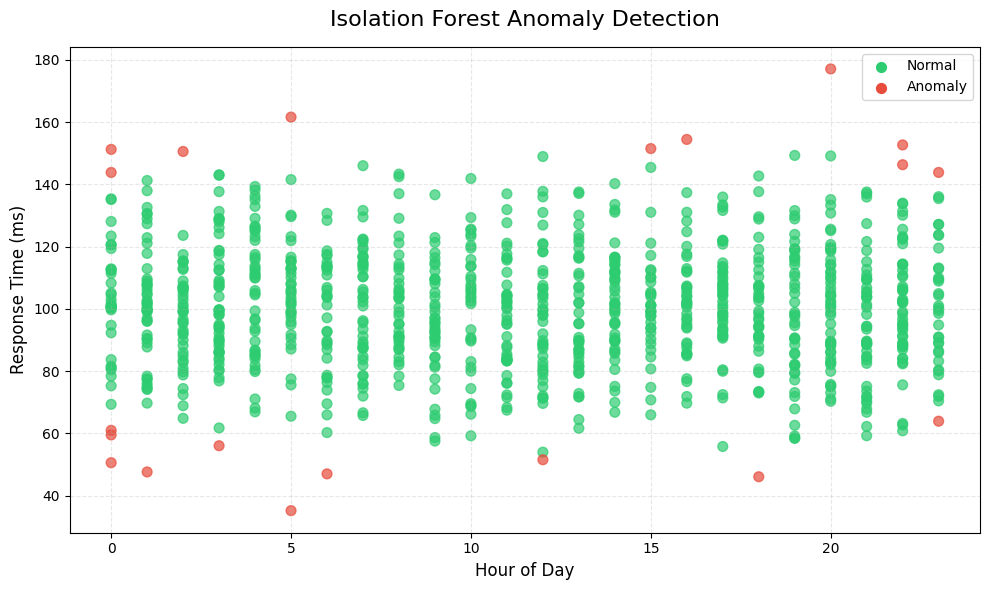

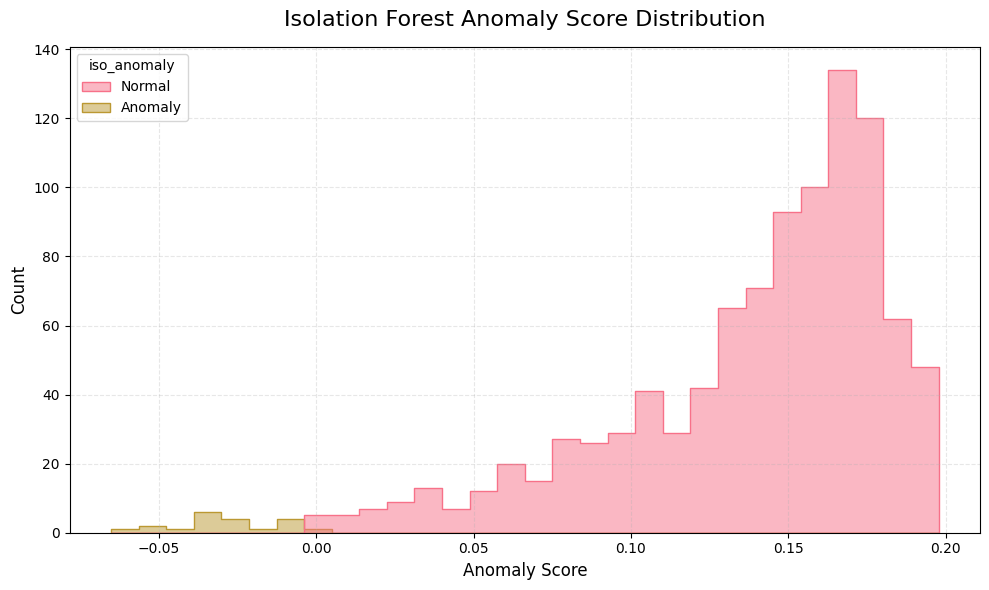

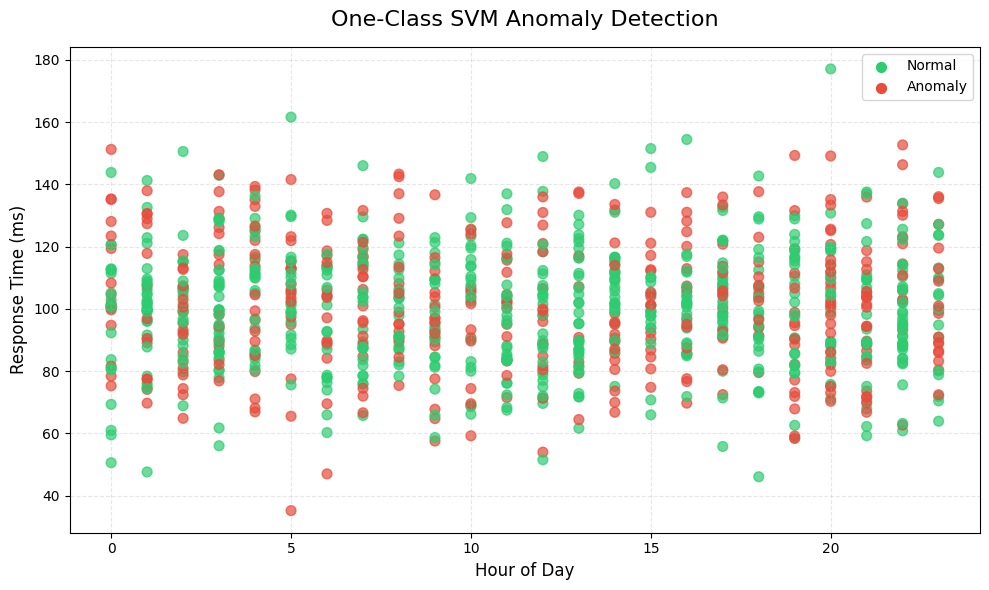

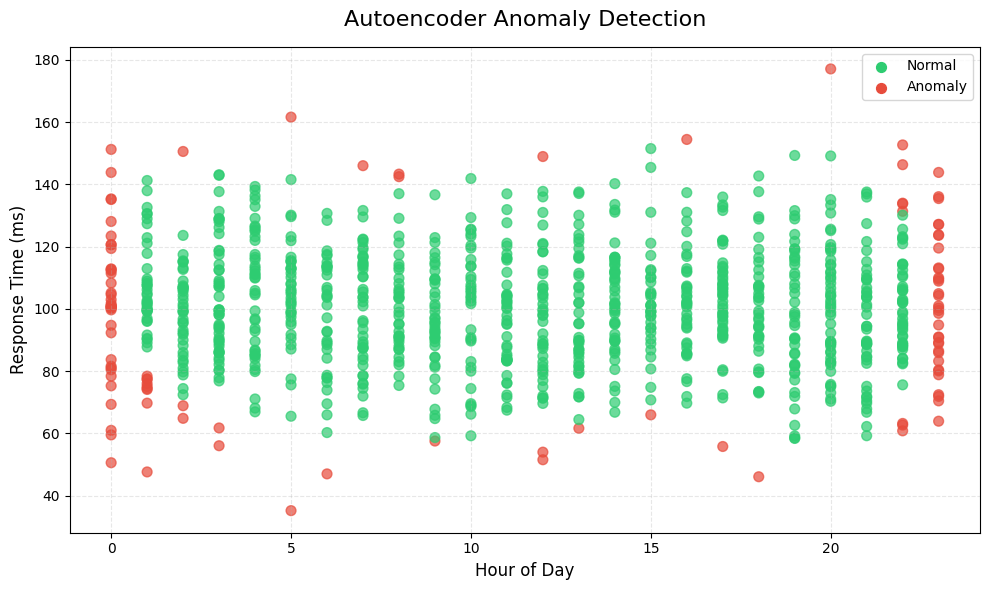

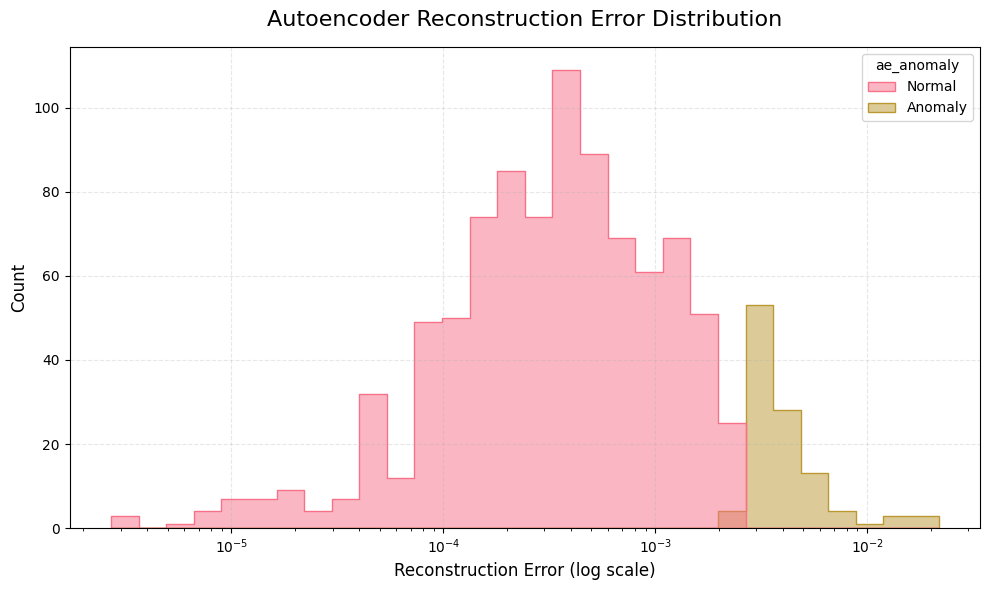


--- Isolation Forest Results ---
     response_time_ms  hour  iso_anomaly_score iso_anomaly
0          131.584256    17           0.112814      Normal
1          115.348695    19           0.160681      Normal
2           90.610512    14           0.175263      Normal
3          110.851201     6           0.168902      Normal
4           90.731646    10           0.163690      Normal
..                ...   ...                ...         ...
995        118.492674    19           0.148271      Normal
996        101.192607    15           0.189481      Normal
997         87.061264    14           0.168713      Normal
998        113.964466    14           0.186040      Normal
999        107.869708     5           0.171183      Normal

[1000 rows x 4 columns]

--- One-Class SVM Results ---
     response_time_ms  hour svm_anomaly
0          131.584256    17      Normal
1          115.348695    19      Normal
2           90.610512    14      Normal
3          110.851201     6      Normal
4 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# [Assuming previous cells have run and df_logs is available with features]

# Function definitions (unchanged from your code)
def isolation_forest_anomaly(df_logs, features):
    iso_model = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
    iso_model.fit(features)
    df_logs['iso_anomaly_score'] = iso_model.decision_function(features)
    df_logs['iso_anomaly'] = iso_model.predict(features)
    df_logs['iso_anomaly'] = df_logs['iso_anomaly'].map({1: 'Normal', -1: 'Anomaly'})
    return df_logs

def one_class_svm_anomaly(df_logs, features):
    svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm_model.fit(features)
    df_logs['svm_anomaly'] = svm_model.predict(features)
    df_logs['svm_anomaly'] = df_logs['svm_anomaly'].map({1: 'Normal', -1: 'Anomaly'})
    return df_logs

def autoencoder_anomaly(df_logs, features):
    scaler_ae = MinMaxScaler()
    X_scaled = scaler_ae.fit_transform(features)
    input_dim = X_scaled.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, 
                   validation_split=0.1, verbose=0, callbacks=[early_stopping])

    reconstructions = autoencoder.predict(X_scaled)
    mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
    df_logs['reconstruction_error'] = mse

    Q1 = np.percentile(mse, 25)
    Q3 = np.percentile(mse, 75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    df_logs['ae_anomaly'] = df_logs['reconstruction_error'].apply(lambda x: 'Anomaly' if x > threshold else 'Normal')
    return df_logs

# Prepare feature matrix
features = df_logs[['response_time_ms', 'hour']].dropna()

# Apply anomaly detection models
df_logs = isolation_forest_anomaly(df_logs, features)
df_logs = one_class_svm_anomaly(df_logs, features)
df_logs = autoencoder_anomaly(df_logs, features)

# --- Visualizations ---
plt.style.use('default')
sns.set_palette("husl")

# 1. Isolation Forest Visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_logs['hour'], df_logs['response_time_ms'], 
           c=df_logs['iso_anomaly'].map({'Normal': '#2ecc71', 'Anomaly': '#e74c3c'}),
           alpha=0.7, s=50)
plt.title('Isolation Forest Anomaly Detection', fontsize=16, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Response Time (ms)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(handles=[
    plt.scatter([], [], c='#2ecc71', label='Normal', s=50),
    plt.scatter([], [], c='#e74c3c', label='Anomaly', s=50)
], fontsize=10, loc='upper right')
plt.tight_layout()
plt.savefig('iso_forest_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Isolation Forest Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_logs, x='iso_anomaly_score', hue='iso_anomaly', 
            bins=30, element='step', alpha=0.5)
plt.title('Isolation Forest Anomaly Score Distribution', fontsize=16, pad=15)
plt.xlabel('Anomaly Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('iso_score_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. One-Class SVM Visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_logs['hour'], df_logs['response_time_ms'],
           c=df_logs['svm_anomaly'].map({'Normal': '#2ecc71', 'Anomaly': '#e74c3c'}),
           alpha=0.7, s=50)
plt.title('One-Class SVM Anomaly Detection', fontsize=16, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Response Time (ms)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(handles=[
    plt.scatter([], [], c='#2ecc71', label='Normal', s=50),
    plt.scatter([], [], c='#e74c3c', label='Anomaly', s=50)
], fontsize=10, loc='upper right')
plt.tight_layout()
plt.savefig('svm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Autoencoder Visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_logs['hour'], df_logs['response_time_ms'],
           c=df_logs['ae_anomaly'].map({'Normal': '#2ecc71', 'Anomaly': '#e74c3c'}),
           alpha=0.7, s=50)
plt.title('Autoencoder Anomaly Detection', fontsize=16, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Response Time (ms)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(handles=[
    plt.scatter([], [], c='#2ecc71', label='Normal', s=50),
    plt.scatter([], [], c='#e74c3c', label='Anomaly', s=50)
], fontsize=10, loc='upper right')
plt.tight_layout()
plt.savefig('autoencoder_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Autoencoder Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_logs, x='reconstruction_error', hue='ae_anomaly',
            bins=30, element='step', alpha=0.5, log_scale=(True, False))
plt.title('Autoencoder Reconstruction Error Distribution', fontsize=16, pad=15)
plt.xlabel('Reconstruction Error (log scale)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('ae_error_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Display Results ---
iso_results = df_logs[['response_time_ms', 'hour', 'iso_anomaly_score', 'iso_anomaly']]
print("\n--- Isolation Forest Results ---")
print(iso_results)

svm_results = df_logs[['response_time_ms', 'hour', 'svm_anomaly']]
print("\n--- One-Class SVM Results ---")
print(svm_results)

ae_results = df_logs[['response_time_ms', 'hour', 'reconstruction_error', 'ae_anomaly']]
print("\n--- Autoencoder Results ---")
print(ae_results)

In [4]:
# Inspecting the dataset columns
import pandas as pd
df = pd.read_csv("synthetic_logs.csv")
df.head()

,timestamp,method,endpoint,status_code,size,response_time
0,2025-01-01 00:11:13,DELETE,/usr,303,5027,130
1,2025-01-01 00:56:48,POST,/usr/login,304,5036,353
2,2025-01-01 00:26:13,GET,/usr/admin/developer,403,5006,8126
3,2025-01-01 00:50:19,PUT,/usr/admin/developer,404,4986,332
4,2025-01-01 00:38:11,POST,/usr/login,502,4992,355
